In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd ..

/home/rainorangelemon/Documents/tiny-diffusion


/home/rainorangelemon/micromamba/envs/sam2/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
import os
from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from omegaconf import OmegaConf
import torch as th
from scripts.best_of_n_on_sam_dataset import create_model_and_diffusion, CLEVRPosDataset, conditions_denoise_fn_factory, make_estimate_neg_logp
from pathlib import Path
import numpy as np
from PIL import Image

/home/rainorangelemon/Documents/tiny-diffusion/scripts/best_of_n_on_sam_dataset.py:480: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path="../conf")


In [4]:
with initialize(config_path="../conf", version_base="1.1"):
    cfg = compose(config_name="clevr_pos",
                  overrides=["num_constraints=5",
                             "experiment_name=probe_latent_image",
                             # "ckpt_path=ComposableDiff/models/ema_runpod_370000.pt",
                             # "model.noise_schedule=linear",
                            ])

/home/rainorangelemon/micromamba/envs/sam2/lib/python3.10/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'clevr_pos': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


In [5]:
# Setup
th.set_float32_matmul_precision('high')
th.set_grad_enabled(False)
has_cuda = th.cuda.is_available()
device = th.device('cpu' if not has_cuda else 'cuda')

options = OmegaConf.to_container(cfg.model, resolve=True)

options["use_fp16"] = th.cuda.is_available()

model, diffusion = create_model_and_diffusion(**options)

model.eval()
if options['use_fp16']:
    model.convert_to_fp16()
model.to(device)

print(f'Loading checkpoint from {cfg.ckpt_path}')
checkpoint = th.load(cfg.ckpt_path, map_location='cpu')
model.load_state_dict(checkpoint)

print('Total base parameters', sum(x.numel() for x in model.parameters()))

# Create output directory
output_dir = Path(cfg.output_dir)
experiment_name = cfg.data_path.split('/')[-1].split('.')[0]
output_dir = output_dir / experiment_name
output_dir.mkdir(parents=True, exist_ok=True)

# Save the config
config_save_path = os.path.join(cfg.output_dir, "config.yaml")
with open(config_save_path, "w") as f:
    f.write(OmegaConf.to_yaml(cfg))

dataset = CLEVRPosDataset(data_path=cfg.data_path)

Loading checkpoint from ComposableDiff/models/clevr_pos.pt


/tmp/ipykernel_1152444/3261124727.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = th.load(cfg.ckpt_path, map_location='cpu')


Total base parameters 224779782


In [6]:
from scripts.best_of_n_on_sam_dataset import add_noise_at_t, remove_noise_to_t

condition_idx = 1
test_idx = 1
positive_ims = [np.array(Image.open(f"runs/10-21_17-39-55/test_clevr_pos_5000_5/original_sample_{test_idx:05d}_{i:05d}.png").convert("RGB")) for i in [3, 6, 20, 31, 45, 46, 69, 76, 77, 82]]
negative_ims = [np.array(Image.open(f"runs/10-21_17-39-55/test_clevr_pos_5000_5/original_sample_{test_idx:05d}_{i:05d}.png").convert("RGB")) for i in [81, 83, 53, 29, 16, 13, 11, 00, 74, 47]]
labels, _ = dataset[test_idx]

conditions_denoise_fn = conditions_denoise_fn_factory(model, th.tensor(labels[np.newaxis], dtype=th.float32),
                                                        batch_size=cfg.elbo.mini_batch, cfg=cfg)
estimate_neg_logp = make_estimate_neg_logp(elbo_cfg=cfg.elbo,
                                                        noise_scheduler=diffusion,
                                                        unconditioned_denoise_fn=conditions_denoise_fn[-1],
                                                        mini_batch=cfg.elbo.mini_batch,
                                                        progress=True)


all_samples = th.from_numpy(np.stack(positive_ims + negative_ims)).to(device).permute(0, 3, 1, 2).float()
# normalize the images
all_samples = (all_samples / 255.0) * 2.0 - 1.0

# set the region around label to 0
coord = labels[condition_idx]
coord = coord.copy()
coord[0] = coord[0] * 128
coord[1] = (1 - coord[1]) * 128
coord = coord.astype(np.int32)


def predict_noise(all_samples, noise, timesteps_t, k):
    timesteps_k = th.full((len(all_samples),), k, dtype=th.long, device=all_samples.device)
    noisy_x = add_noise_at_t(diffusion.base_diffusion, all_samples, noise, timesteps_t, timesteps_k)

        # check the predicted x0
    pred = conditions_denoise_fn[condition_idx](noisy_x, timesteps_k)
    predicted_noise = pred[:, :3]
    model_var_values = pred[:, 3:]

        # get the variance of the predicted noise
    min_log = diffusion.base_diffusion.posterior_log_variance_clipped[k]
    max_log = np.log(diffusion.base_diffusion.betas)[k]
        # The model_var_values is [-1, 1] for [min_var, max_var].
    frac = (model_var_values + 1) / 2
    model_log_variance = frac * max_log + (1 - frac) * min_log
    model_variance = th.exp(model_log_variance)

    x0 = remove_noise_to_t(diffusion.base_diffusion, noisy_x, predicted_noise, timesteps_t, timesteps_k)

    pred_uncond = conditions_denoise_fn[-1](noisy_x, timesteps_k)
    predicted_noise_uncond = pred_uncond[:, :3]
    model_var_values_uncond = pred_uncond[:, 3:]

    frac_uncond = (model_var_values_uncond + 1) / 2
    model_log_variance_uncond = frac_uncond * max_log + (1 - frac_uncond) * min_log
    model_variance_uncond = th.exp(model_log_variance_uncond)

    x0_uncond = remove_noise_to_t(diffusion.base_diffusion, noisy_x, predicted_noise_uncond, timesteps_t, timesteps_k)
    return predicted_noise, model_variance, predicted_noise_uncond, model_variance_uncond

In [7]:
# generate normal images
import baselines_clevr
from torchvision.utils import make_grid, save_image
th.manual_seed(0)
th.cuda.manual_seed(0)

single_conditioned_samples = \
baselines_clevr.diffusion_baseline(lambda x, t: conditions_denoise_fn[condition_idx](x, t, use_cfg=False),
                                   diffusion,
                                   x_shape=(3, 128, 128),
                                   eval_batch_size=10)[-1]
single_conditioned_samples = th.clamp(single_conditioned_samples, -1, 1)
single_conditioned_samples = single_conditioned_samples.to(device)
single_conditioned_samples_to_render = 0.5 * single_conditioned_samples + 0.5
make_grid(single_conditioned_samples_to_render, nrow=10).permute(1, 2, 0).cpu().numpy()
# save the images
save_image(single_conditioned_samples_to_render, output_dir / f"single_conditioned_samples.png")

  0%|          | 0/100 [00:00<?, ?it/s]

In [8]:
single_conditioned_samples_neg = \
baselines_clevr.diffusion_baseline(lambda x, t: conditions_denoise_fn[condition_idx+3](x, t, use_cfg=False),
                                   diffusion,
                                   x_shape=(3, 128, 128),
                                   eval_batch_size=10)[-1]
single_conditioned_samples_neg = th.clamp(single_conditioned_samples_neg, -1, 1)
single_conditioned_samples_neg = single_conditioned_samples_neg.to(device)
single_conditioned_samples_to_render = 0.5 * single_conditioned_samples_neg + 0.5
make_grid(single_conditioned_samples_to_render, nrow=10).permute(1, 2, 0).cpu().numpy()
# save the images
save_image(single_conditioned_samples_to_render, output_dir / f"single_conditioned_samples_neg.png")

  0%|          | 0/100 [00:00<?, ?it/s]

In [9]:
all_samples_single = th.cat([single_conditioned_samples, single_conditioned_samples_neg], dim=0)

In [10]:
from tqdm.auto import tqdm
from sklearn.metrics import roc_auc_score
import wandb
import gc

t_interval = 10

run = wandb.init(project="analyze_logp",
                 name=f"{cfg.experiment_name}",
                 config=OmegaConf.to_container(cfg, resolve=True),
                 entity="rainorangelemon")

packed_predicted_noise_cond = th.zeros((len(all_samples), 1, 1000 // t_interval, 3, 128, 128), device="cpu")
packed_predicted_noise_uncond = th.zeros((len(all_samples_single), 1, 1000 // t_interval, 3, 128, 128), device="cpu")
packed_l2_distance_diff = th.zeros((len(all_samples_single), 1, 1000 // t_interval), device="cpu")

for seed in range(1):
        gc.collect()

        th.manual_seed(seed)
        th.cuda.manual_seed(seed)
        noise = th.randn_like(all_samples[0, ...], device=all_samples.device)[None, ...]#.expand(len(all_samples), -1, -1, -1)
        timesteps_t = th.full((len(all_samples),), 0, dtype=th.long, device=all_samples.device)


        for idx_k, k in tqdm(zip(range(1000 // t_interval), range(0, 1000, t_interval))):
                predicted_noise, model_variance, predicted_noise_uncond, model_variance_uncond = predict_noise(all_samples, noise, timesteps_t, k)

                # get the L2 distance
                l2_distance = (predicted_noise - noise).pow(2).sum(dim=(1, 2, 3)) # / model_variance_uncond
                cosine_distance = th.nn.functional.cosine_similarity(predicted_noise.flatten(1), noise.flatten(1), dim=1)

                l2_distance_uncond = (predicted_noise_uncond - noise).pow(2).sum(dim=(1, 2, 3)) # / model_variance_uncond
                cosine_distance_uncond = th.nn.functional.cosine_similarity(predicted_noise_uncond.flatten(1), noise.flatten(1), dim=1)

                packed_predicted_noise_cond[:, seed, idx_k] = predicted_noise #/ model_variance_single).sum(dim=(1, 2, 3))
                packed_predicted_noise_uncond[:, seed, idx_k] = predicted_noise_uncond #/ model_variance_uncond_single).sum(dim=(1, 2, 3))

                l2_distance_diff = l2_distance - l2_distance_uncond
                cosine_distance_diff = cosine_distance - cosine_distance_uncond

                packed_l2_distance_diff[:, seed, idx_k] = l2_distance_diff

                # l2_distance_diff_cfg = l2_distance_uncond + (cfg.cfg_weight - 1) * l2_distance_diff
                # cosine_distance_diff_cfg = cosine_distance_uncond + (cfg.cfg_weight - 1) * cosine_distance_diff

                # get the L2 distance for the single conditioned samples
                predicted_noise_single, model_variance_single, predict_noise_uncond_single, model_variance_uncond_single = \
                        predict_noise(all_samples_single, noise, timesteps_t[:len(all_samples_single)], k)

                # use scikit to calculate the auc
                labels = [1] * len(positive_ims) + [0] * len(negative_ims)
                auc = roc_auc_score(labels, -l2_distance.cpu().numpy())
                auc_cosine = roc_auc_score(labels, cosine_distance.cpu().numpy())

                auc_uncond = roc_auc_score(labels, -l2_distance_uncond.cpu().numpy())
                auc_cosine_uncond = roc_auc_score(labels, cosine_distance_uncond.cpu().numpy())

                auc_diff = roc_auc_score(labels, -l2_distance_diff.cpu().numpy())
                auc_cosine_diff = roc_auc_score(labels, cosine_distance_diff.cpu().numpy())

                # auc_diff_cfg = roc_auc_score(labels, -l2_distance_diff_cfg.cpu().numpy())
                # auc_cosine_diff_cfg = roc_auc_score(labels, cosine_distance_diff_cfg.cpu().numpy())

                # log to wandb
                wandb.log({
                        f"auc/{seed}": auc,
                        f"auc_cosine/{seed}": auc_cosine,
                        f"auc_uncond/{seed}": auc_uncond,
                        f"auc_cosine_uncond/{seed}": auc_cosine_uncond,
                        f"auc_diff/{seed}": auc_diff,
                        f"auc_cosine_diff/{seed}": auc_cosine_diff,
                        # f"auc_diff_cfg/{seed}": auc_diff_cfg,
                        # f"auc_cosine_diff_cfg/{seed}": auc_cosine_diff_cfg,
                        })

                # # save energy to pt file
                # th.save({"l2_distance": l2_distance,
                #         "cosine_distance": cosine_distance,
                #         "l2_distance_uncond": l2_distance_uncond,
                #         "cosine_distance_uncond": cosine_distance_uncond,
                #         }, output_dir / f"energy_seed_{seed:05d}_timestep_{k:05d}.pt")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: rainorangelemon. Use `wandb login --relogin` to force relogin


0it [00:00, ?it/s]

In [15]:
packed_l2_distance_diff_for_single_origin = packed_l2_distance_diff_for_single.clone()
packed_l2_distance_diff_origin = packed_l2_distance_diff.clone()

In [16]:
packed_l2_distance_diff_for_single = packed_l2_distance_diff_for_single_origin.mean(dim=1)
packed_l2_distance_diff = packed_l2_distance_diff_origin.mean(dim=1)

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
# plot (packed_l2_distance_diff_for_single).max()
plt.clf()
plt.close("all")
plt.plot(packed_l2_distance_diff_for_single[:10].mean(dim=0).cpu().numpy())
# also plot the deviation band
plt.fill_between(range(1000), packed_l2_distance_diff_for_single[:10].max(dim=0)[0].cpu().numpy(), packed_l2_distance_diff_for_single[:10].min(dim=0)[0].cpu().numpy(), alpha=0.3)
plt.plot(packed_l2_distance_diff[:10].mean(dim=0).cpu().numpy())
# symmetric log
plt.yscale("symlog")
plt.axhline(0, color='gray', linestyle='--')
plt.title("L2 distance difference for single conditioned samples (positive)")
plt.show()

import matplotlib.pyplot as plt
# plot (packed_l2_distance_diff_for_single).max()
plt.clf()
plt.close("all")
plt.plot(packed_l2_distance_diff_for_single[10:].mean(dim=0).cpu().numpy())
# also plot the deviation band
plt.fill_between(range(1000), packed_l2_distance_diff_for_single[10:].max(dim=0)[0].cpu().numpy(), packed_l2_distance_diff_for_single[10:].min(dim=0)[0].cpu().numpy(), alpha=0.3)
# symmetric log
plt.yscale("symlog")
plt.axhline(0, color='gray', linestyle='--')
plt.title("L2 distance difference for single conditioned samples (negative)")
plt.show()

NameError: name 'packed_l2_distance_diff_for_single' is not defined

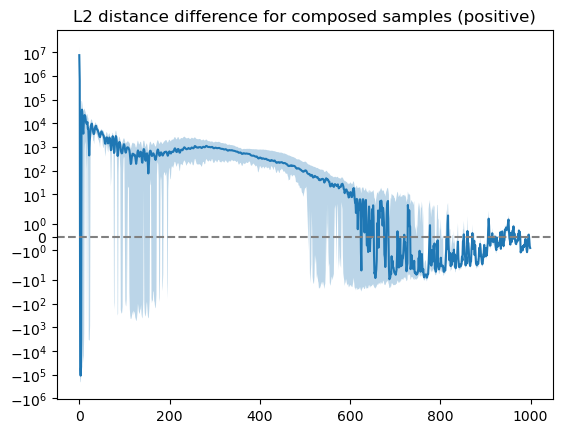

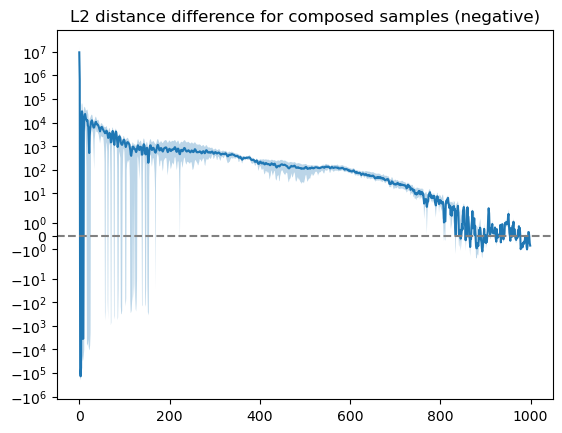

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.clf()
plt.close("all")
plt.plot(packed_l2_distance_diff[:10].mean(dim=0).cpu().numpy())
# also plot the deviation band
plt.fill_between(range(1000), packed_l2_distance_diff[:10].max(dim=0)[0].cpu().numpy(), packed_l2_distance_diff[:10].min(dim=0)[0].cpu().numpy(), alpha=0.3)
# symmetric log
plt.yscale("symlog")
plt.axhline(0, color='gray', linestyle='--')
plt.title("L2 distance difference for composed samples (positive)")
plt.show()


import matplotlib.pyplot as plt
plt.clf()
plt.close("all")
plt.plot(packed_l2_distance_diff[10:].mean(dim=0).cpu().numpy())
# also plot the deviation band
plt.fill_between(range(1000), packed_l2_distance_diff[10:].max(dim=0)[0].cpu().numpy(), packed_l2_distance_diff[10:].min(dim=0)[0].cpu().numpy(), alpha=0.3)
# symmetric log
plt.yscale("symlog")
plt.axhline(0, color='gray', linestyle='--')
plt.title("L2 distance difference for composed samples (negative)")
plt.show()

# Visualize the Heatmap

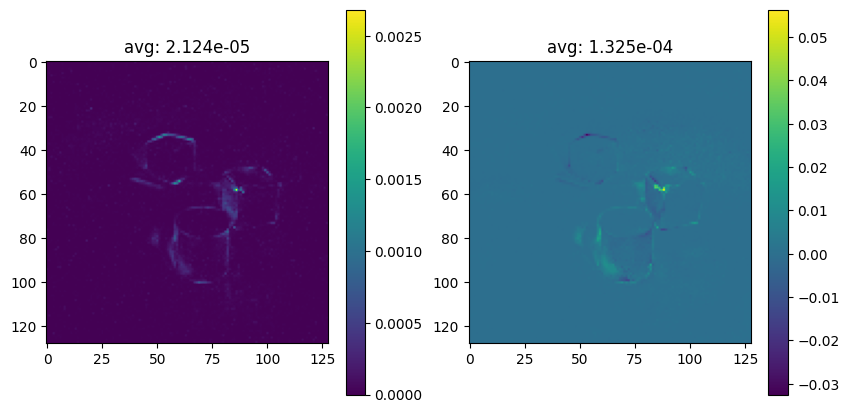

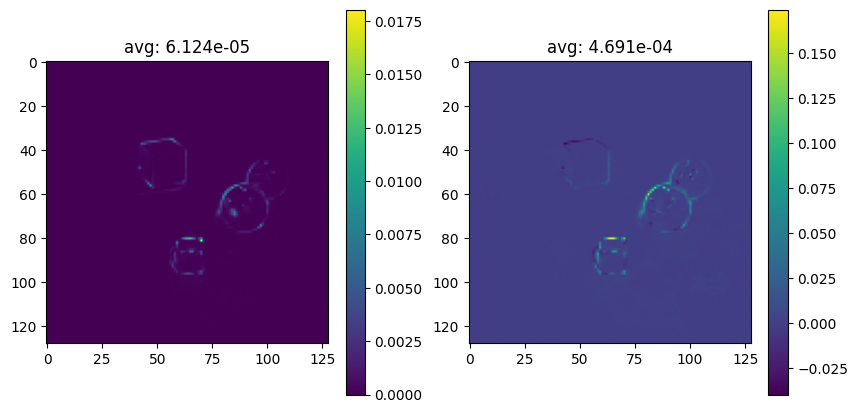

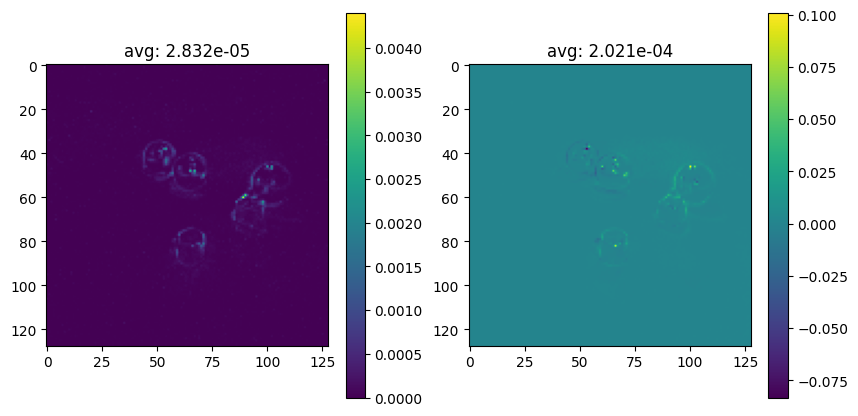

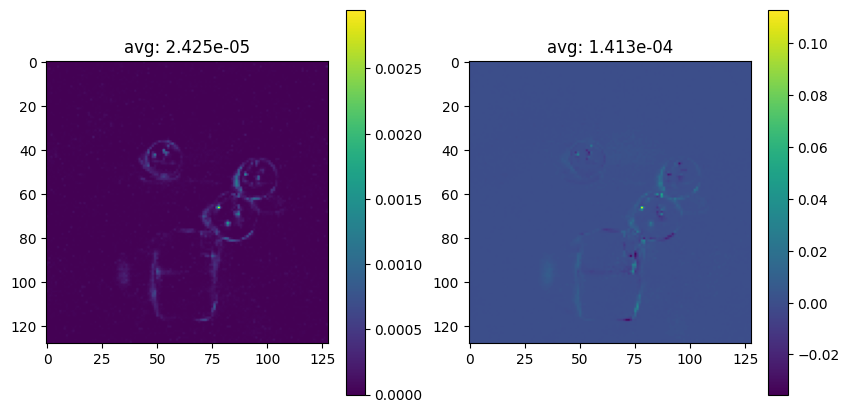

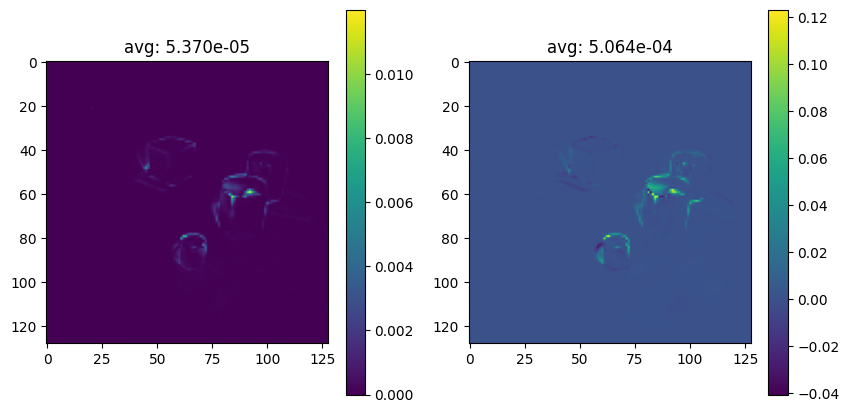

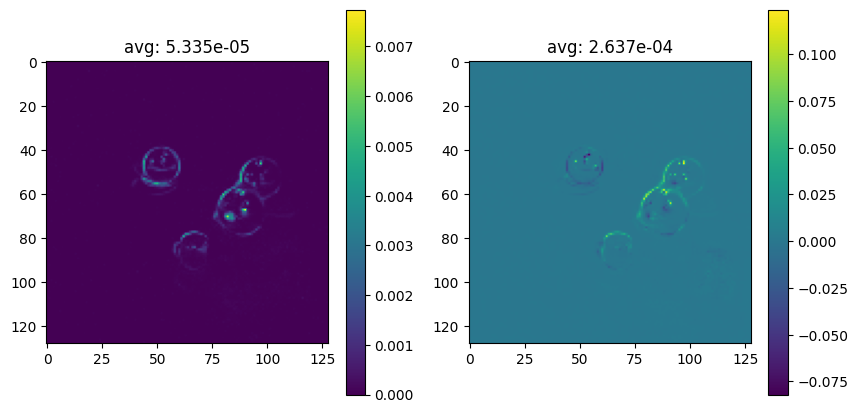

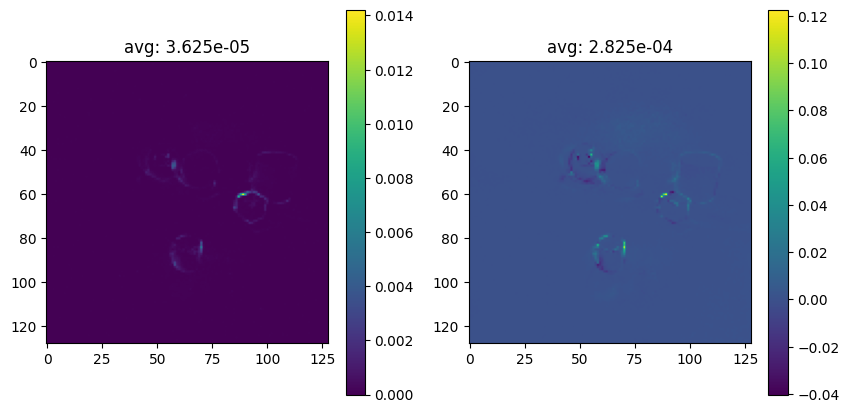

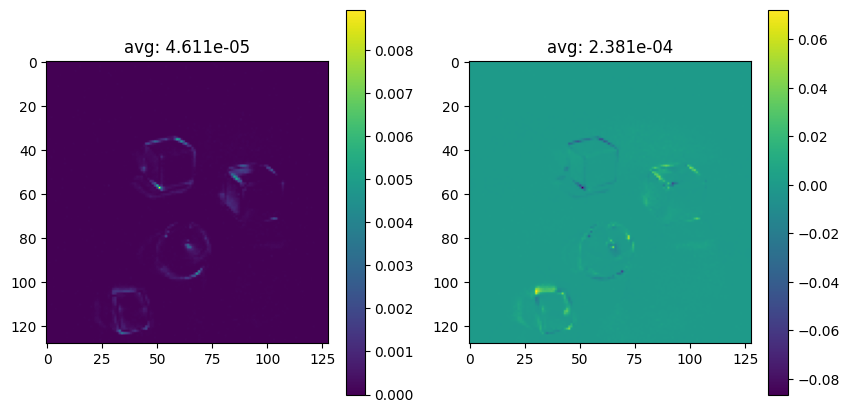

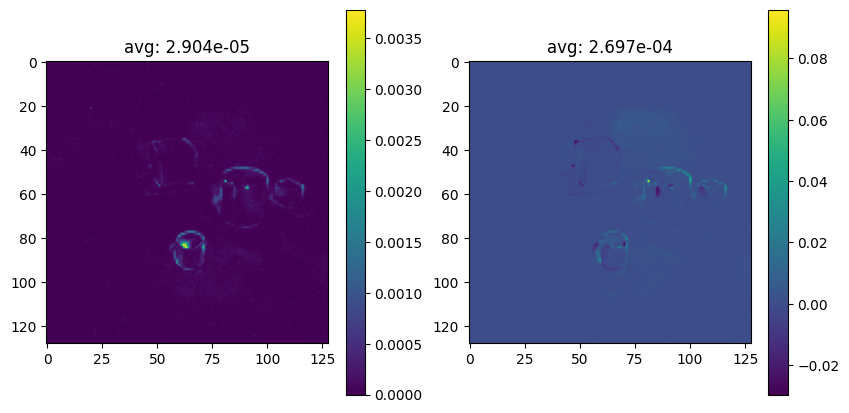

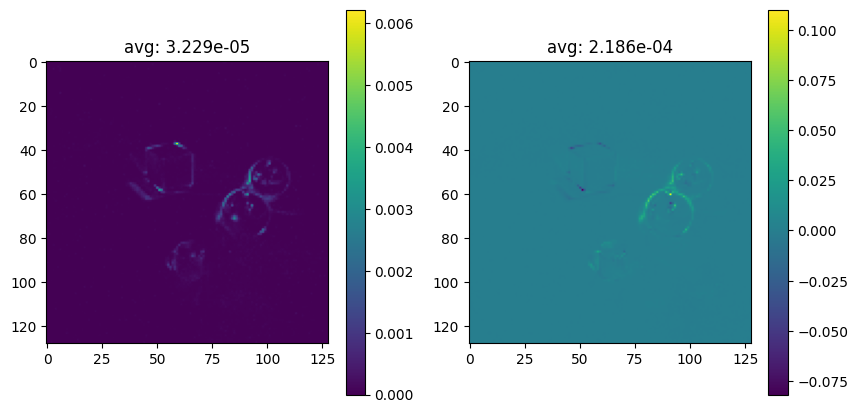

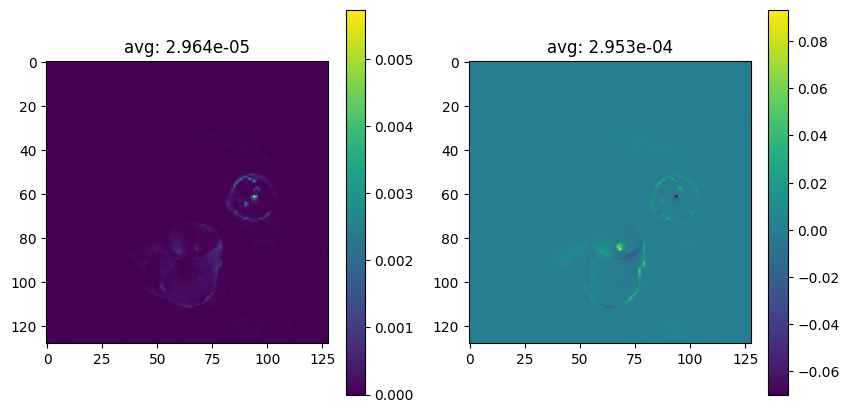

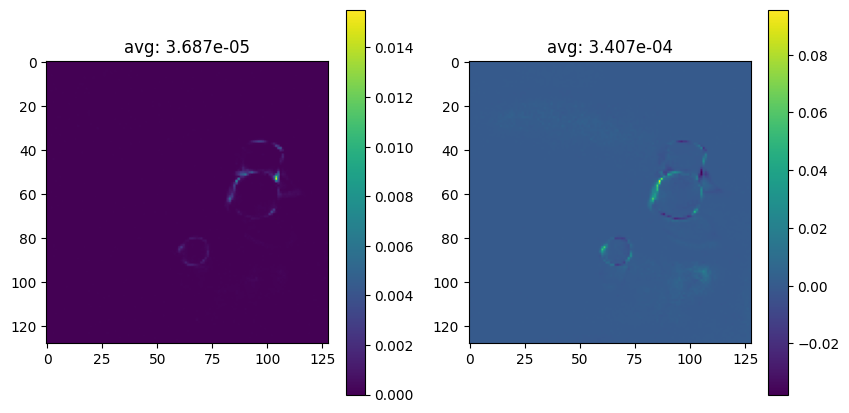

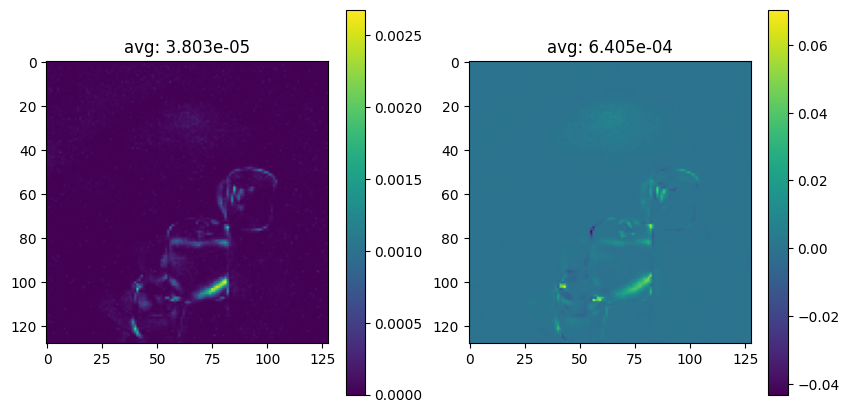

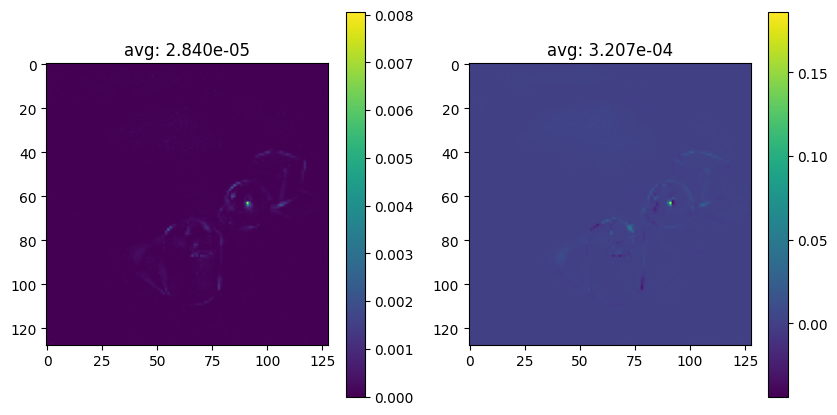

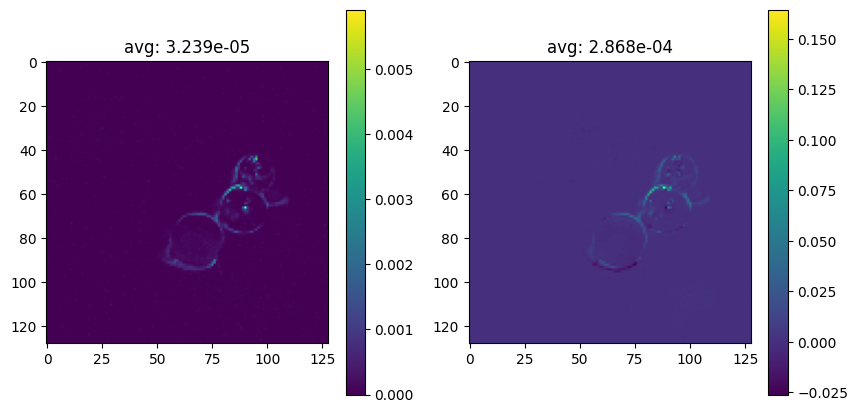

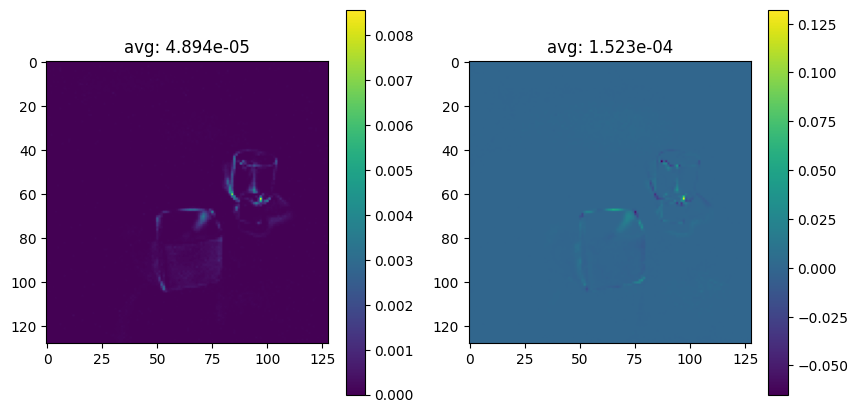

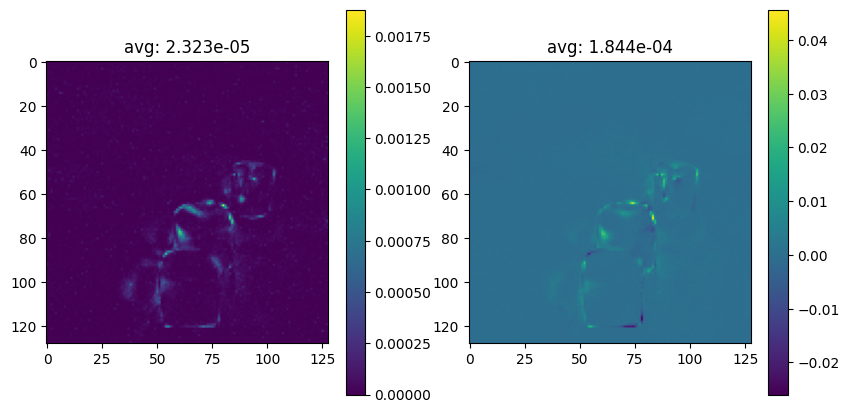

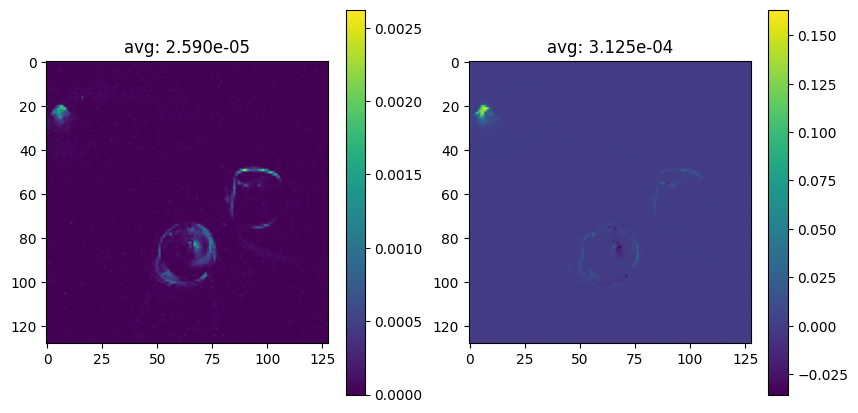

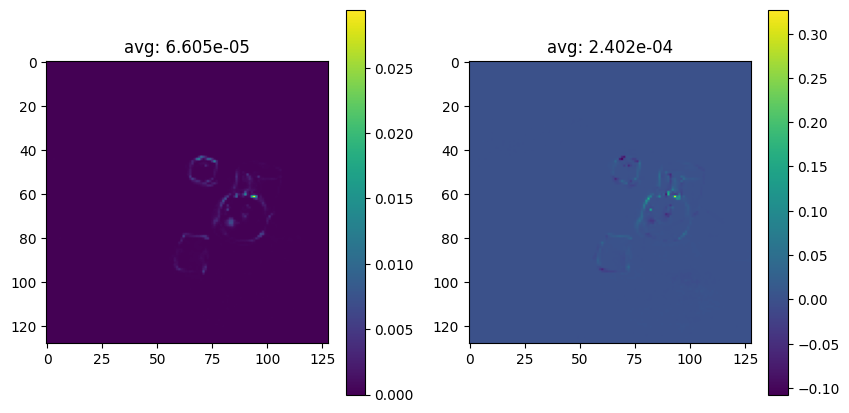

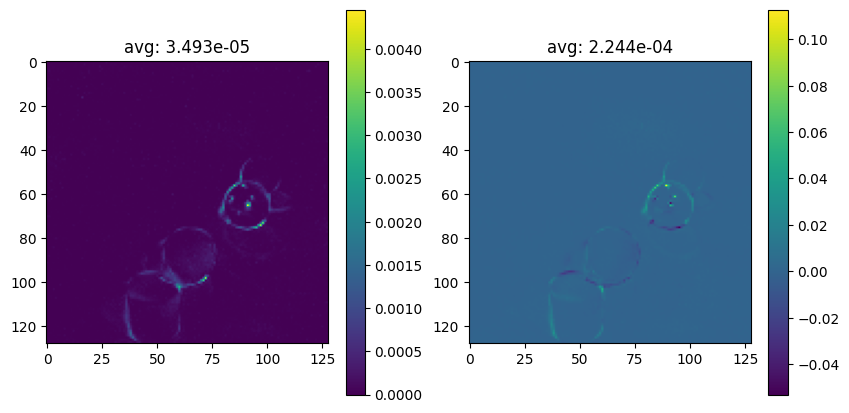

In [17]:
t = [20] # list(range(100))
noise = noise.cpu()
# average over the seeds, timesteps, and channels
heatmap_1 = (packed_predicted_noise_cond[:, :, t] - packed_predicted_noise_uncond[:, :, t]).pow(2).mean(dim=(1, 2, 3))
heatmap_2 = ((noise - packed_predicted_noise_uncond[:, :, t]).pow(2) - (noise - packed_predicted_noise_cond[:, :, t]).pow(2)).mean(dim=(1, 2, 3))
for img_idx in range(len(all_samples)):
    import matplotlib.pyplot as plt
    plt.clf()
    plt.close("all")
    _, ax = plt.subplots(1, 2, figsize=(10, 5))
    im1 = ax[0].imshow(heatmap_1[img_idx].cpu().numpy())
    ax[0].set_title(f"avg: {heatmap_1[img_idx].cpu().numpy().mean():.3e}")
    im2 = ax[1].imshow(heatmap_2[img_idx].cpu().numpy())
    ax[1].set_title(f"avg: {heatmap_2[img_idx].cpu().numpy().mean():.3e}")
    # colorbar
    plt.colorbar(im1, ax=ax[0])
    plt.colorbar(im2, ax=ax[1])
    plt.show()
